In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import lightgbm as lgb

In [2]:
df = pd.read_csv('./raw_data.csv')
df

,report_date,amount,is_workday,day_of_the_week
0,20170322,128889919,1,2
1,20170324,123863161,1,4
2,20170326,104586428,0,6
3,20170331,130570437,1,4
4,20170402,156932119,0,6
...,...,...,...,...
968,20191102,578548087,0,5
969,20191106,607952700,1,2
970,20191108,620204346,1,4
971,20191109,647024387,0,5


# FEATURES

In [3]:
df['report_date'] = df['report_date'].astype(str)
df = df.sort_values('report_date')

def precision_compute(pred_num, real_num):
    if real_num == 0:
        return 1.0
    return 1 - np.abs(pred_num - real_num) / real_num

results = []
predictday = 0
print("predictday",predictday + 1)
df_feature = df.copy()
df_feature['report_date2'] = pd.to_datetime(df_feature['report_date'])
df_feature['day'] = df_feature['report_date2'].map(lambda x:x.day)
df_feature['month'] = df_feature['report_date2'].map(lambda x:x.month)
df_feature['year'] = df_feature['report_date2'].map(lambda x:x.year)
df_feature['is_workday'] = df_feature['is_workday'].astype(int)
df_feature['day_of_the_week'] = df_feature['day_of_the_week'].astype(int)
df_feature['amount'] = df_feature['amount'].map(lambda x:int(x)/10**5).astype(int)
del df_feature['report_date2']

cache = df_feature[['report_date','amount','is_workday']].values

amounts = []

amount_label2 = []
workday = 0

last_amount = []
min_amount_3 = []
max_amount_3 = []
mean_amount_3 = []
std_amount_3 = []
min_amount_7 = []
max_amount_7 = []
mean_amount_7 = []
std_amount_7 = []
min_amount_14 = []
max_amount_14 = []
mean_amount_14 = []
std_amount_14 = []
min_amount_30 = []
max_amount_30 = []
mean_amount_30 = []
std_amount_30 = []
continueworkday = []

amounts.append(cache[0,1])
for i in range(predictday):  # padding
    amounts.append(cache[0,1])

for i in range(cache.shape[0]):
    amount = cache[i,1]
    if cache[i,2] == 1:
        workday += 1
    else:
        workday = 0
    continueworkday.append(workday)


    # sliding window
    for length in [3,7,14,30]:
        if predictday != 0:
            l = amounts[-length:-predictday]
        else:
            l = amounts[-length:]
        if len(l) == 0:
            l = [amount]
        eval('min_amount_' + str(length)).append(min(l))
        eval('max_amount_' + str(length)).append(max(l))
        eval('mean_amount_' + str(length)).append(np.mean(l))
        eval('std_amount_' + str(length)).append(np.std(l))
    amount_label2.append(amount / amounts[-1 - predictday])
    last_amount.append(amounts[-1 - predictday])
    amounts.append(amount)

df_feature['amount2'] = np.array(amount_label2)
df_feature['last_amount'] = np.array(last_amount)
for length in [3,7,14,30]:
    df_feature['min_amount_' + str(length)] = np.array(eval('min_amount_' + str(length)))
    df_feature['max_amount_' + str(length)] = np.array(eval('max_amount_' + str(length)))
    df_feature['mean_amount_' + str(length)] = np.array(eval('mean_amount_' + str(length)))
    df_feature['std_amount_' + str(length)] = np.array(eval('std_amount_' + str(length)))

predictday 1


# NN MODEL

In [4]:
import keras
import random
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

def create_model(loss_fn,X_tr):
    inps = Input(shape=(X_tr.shape[1],))
    x = Dense(512, activation='relu')(inps)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='relu')(x)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer='adam',
        loss=[loss_fn]
    )
    #model.summary()
    return model


import datetime
startdate = "20191015"
features = [x for x in df_feature.columns if x not in ['report_date','amount','amount2']]

num_labels = 2  # two task


target = ['amount2','amount']  
X_train = df_feature[df_feature['report_date']<startdate][features]
y_train = df_feature[df_feature['report_date']<startdate][target].values
X_valid = df_feature[df_feature['report_date']>=startdate][features]
y_valid = df_feature[df_feature['report_date']>=startdate][target].values



model = create_model('mape',X_train)
model.fit(
    X_train, y_train, epochs=500, batch_size=25, validation_data=(X_valid, y_valid), verbose=True)
del model
import gc
gc.collect()

Using TensorFlow backend.


Epoch 1/500
38/38 [==============================] - 0s 9ms/step - loss: 90.6070 - val_loss: 100.0000
Epoch 2/500
38/38 [==============================] - 0s 4ms/step - loss: 83.0337 - val_loss: 100.0000
Epoch 3/500
38/38 [==============================] - 0s 4ms/step - loss: 80.4516 - val_loss: 57.4738
Epoch 4/500
38/38 [==============================] - 0s 3ms/step - loss: 78.3150 - val_loss: 65.9719
Epoch 5/500
38/38 [==============================] - 0s 5ms/step - loss: 75.3061 - val_loss: 79.8132
Epoch 6/500
38/38 [==============================] - 0s 3ms/step - loss: 71.9679 - val_loss: 56.8308
Epoch 7/500
38/38 [==============================] - 0s 4ms/step - loss: 71.2557 - val_loss: 57.2107
Epoch 8/500
38/38 [==============================] - 0s 5ms/step - loss: 70.0611 - val_loss: 65.5547
Epoch 9/500
38/38 [==============================] - 0s 3ms/step - loss: 68.3002 - val_loss: 55.1020
Epoch 10/500
38/38 [==============================] - 0s 4ms/step - loss: 69.0603 - val_l

Epoch 161/500
38/38 [==============================] - 0s 4ms/step - loss: 39.4590 - val_loss: 37.9722
Epoch 162/500
38/38 [==============================] - 0s 4ms/step - loss: 39.2508 - val_loss: 36.2872
Epoch 163/500
38/38 [==============================] - 0s 3ms/step - loss: 38.8724 - val_loss: 35.2424
Epoch 164/500
38/38 [==============================] - 0s 5ms/step - loss: 38.5191 - val_loss: 34.0425
Epoch 165/500
38/38 [==============================] - 0s 3ms/step - loss: 38.8792 - val_loss: 31.2496
Epoch 166/500
38/38 [==============================] - 0s 4ms/step - loss: 39.0280 - val_loss: 41.6097
Epoch 167/500
38/38 [==============================] - 0s 3ms/step - loss: 38.9054 - val_loss: 32.5330
Epoch 168/500
38/38 [==============================] - 0s 4ms/step - loss: 38.0065 - val_loss: 31.1652
Epoch 169/500
38/38 [==============================] - 0s 5ms/step - loss: 38.0605 - val_loss: 30.3782
Epoch 170/500
38/38 [==============================] - 0s 3ms/step - loss

38/38 [==============================] - 0s 4ms/step - loss: 12.5088 - val_loss: 6.7919
Epoch 321/500
38/38 [==============================] - 0s 3ms/step - loss: 12.8472 - val_loss: 9.2962
Epoch 322/500
38/38 [==============================] - 0s 4ms/step - loss: 11.3660 - val_loss: 6.8030
Epoch 323/500
38/38 [==============================] - 0s 3ms/step - loss: 11.6909 - val_loss: 7.6236
Epoch 324/500
38/38 [==============================] - 0s 4ms/step - loss: 12.2402 - val_loss: 7.6986
Epoch 325/500
38/38 [==============================] - 0s 4ms/step - loss: 11.1223 - val_loss: 6.8639
Epoch 326/500
38/38 [==============================] - 0s 3ms/step - loss: 11.8420 - val_loss: 9.0039
Epoch 327/500
38/38 [==============================] - 0s 4ms/step - loss: 12.8036 - val_loss: 7.2418
Epoch 328/500
38/38 [==============================] - 0s 4ms/step - loss: 12.9381 - val_loss: 10.0494
Epoch 329/500
38/38 [==============================] - 0s 4ms/step - loss: 13.4443 - val_loss: 

38/38 [==============================] - 0s 3ms/step - loss: 11.5339 - val_loss: 7.1330
Epoch 481/500
38/38 [==============================] - 0s 5ms/step - loss: 11.6248 - val_loss: 7.3307
Epoch 482/500
38/38 [==============================] - 0s 3ms/step - loss: 11.0959 - val_loss: 7.0405
Epoch 483/500
38/38 [==============================] - 0s 5ms/step - loss: 11.3660 - val_loss: 10.2431
Epoch 484/500
38/38 [==============================] - 0s 3ms/step - loss: 11.7885 - val_loss: 9.5090
Epoch 485/500
38/38 [==============================] - 0s 4ms/step - loss: 11.7970 - val_loss: 6.9992
Epoch 486/500
38/38 [==============================] - 0s 4ms/step - loss: 11.9613 - val_loss: 8.1051
Epoch 487/500
38/38 [==============================] - 0s 3ms/step - loss: 12.5248 - val_loss: 8.3801
Epoch 488/500
38/38 [==============================] - 0s 5ms/step - loss: 12.4931 - val_loss: 6.7323
Epoch 489/500
38/38 [==============================] - 0s 3ms/step - loss: 11.2339 - val_loss: 

11760

# MT-GBM

In [5]:
startdate = "20191015"
features = [x for x in df_feature.columns if x not in ['report_date','amount','amount2']]

num_labels = 2  # 双label

def self_metric(preds, train_data):
    labels = train_data.get_label()
    labels2 = labels.reshape((num_labels,-1)).transpose()[:,1]
    preds2 = preds.reshape((num_labels,-1)).transpose()[:,1]
    score = np.mean((labels2-preds2) ** 2)**0.5
    return 'rmse', score, False

def mymse2(preds, train_data, ep = 0):
    labels = train_data.get_label()
    labels2 = labels.reshape((num_labels,-1)).transpose()    
    preds2 = preds.reshape((num_labels,-1)).transpose()
    grad2 = (preds2 - labels2)                               
    grad = grad2 * np.array([1.5,0.001])                     
    grad = np.sum(grad,axis = 1)
    grad2 = grad2.transpose().reshape((-1))                  
    hess = grad * 0. + 1
    hess2 = grad2 * 0. + 1
    return grad, hess, grad2, hess2                         



param = {
    'num_leaves':48, 
    'max_depth':6,
    'learning_rate':.03,
    'max_bin':200,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'verbose': 5,

    # multitask
    'objective':'custom',           
    'num_labels':num_labels, 
    'tree_learner': 'serial2',
    'num_threads':4}    


target = ['amount2','amount']   # 第一个label为较前一天增长百分比，第二个label为绝对值
X_train = df_feature[df_feature['report_date']<startdate][features]
y_train = df_feature[df_feature['report_date']<startdate][target].values
X_valid = df_feature[df_feature['report_date']>=startdate][features]
y_valid = df_feature[df_feature['report_date']>=startdate][target].values

print(df_feature[target].corr())
print(X_train.shape,X_valid.shape)
print(y_train.shape,y_valid.shape)
evals_result_mt = {}
train_data=lgb.Dataset(X_train,label=y_train)
validation_data=lgb.Dataset(X_valid,label=y_valid)
clf=lgb.train(param,train_data,verbose_eval=10,
                fobj = mymse2,feval = self_metric,
                num_boost_round=200,valid_sets=[train_data,validation_data],
            evals_result=evals_result_mt)
clf.set_num_labels(2)


          amount2    amount
amount2  1.000000  0.094927
amount   0.094927  1.000000
(942, 22) (31, 22)
(942, 2) (31, 2)
[10]	training's rmse: 5181.82	valid_1's rmse: 4431.63
[20]	training's rmse: 3845.48	valid_1's rmse: 3232.4
[30]	training's rmse: 2865.44	valid_1's rmse: 2355.34
[40]	training's rmse: 2148.61	valid_1's rmse: 1715.1
[50]	training's rmse: 1627.61	valid_1's rmse: 1245.1
[60]	training's rmse: 1252.37	valid_1's rmse: 903.056
[70]	training's rmse: 984.776	valid_1's rmse: 655.665
[80]	training's rmse: 797.835	valid_1's rmse: 484.398
[90]	training's rmse: 667.766	valid_1's rmse: 381.847
[100]	training's rmse: 578.947	valid_1's rmse: 331.724
[110]	training's rmse: 521.247	valid_1's rmse: 310.186
[120]	training's rmse: 482.569	valid_1's rmse: 308.206
[130]	training's rmse: 455.571	valid_1's rmse: 316.263
[140]	training's rmse: 436.132	valid_1's rmse: 327.626
[150]	training's rmse: 420.056	valid_1's rmse: 336.824
[160]	training's rmse: 407.328	valid_1's rmse: 344.532
[170]	traini

# LightGBM

In [6]:
startdate = "20191015"
features = [x for x in df_feature.columns if x not in ['report_date','amount','amount2']]
param = {
    'num_leaves':48, 
    'objective':'regression',
    'max_depth':6,
    'learning_rate':.03,
    'max_bin':200,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'verboses':10,
    'metrics':"rmse",
    'num_threads':4}

def self_metric(preds, train_data):
    labels = train_data.get_label()
    score = np.mean(np.abs(labels-preds)/(np.abs(labels)+0.0001))
    return 'self_metric', score, False

target = 'amount'
X_train = df_feature[df_feature['report_date']<startdate][features]
y_train = df_feature[df_feature['report_date']<startdate][target]
X_valid = df_feature[df_feature['report_date']>=startdate][features]
y_valid = df_feature[df_feature['report_date']>=startdate][target]

print(X_train.shape,X_valid.shape)
evals_result_singlelgb = {}
train_data=lgb.Dataset(X_train,label=y_train)
validation_data=lgb.Dataset(X_valid,label=y_valid)
clf=lgb.train(param,train_data,verbose_eval=5,
                num_boost_round=200,valid_sets=[train_data,validation_data],evals_result = evals_result_singlelgb)
clf.set_num_labels(1)


(942, 22) (31, 22)
[5]	training's rmse: 2238.1	valid_1's rmse: 785.518
[10]	training's rmse: 1949.35	valid_1's rmse: 704.933
[15]	training's rmse: 1704.06	valid_1's rmse: 644.393
[20]	training's rmse: 1495.61	valid_1's rmse: 594.076
[25]	training's rmse: 1319.01	valid_1's rmse: 558.21
[30]	training's rmse: 1170.21	valid_1's rmse: 531.221
[35]	training's rmse: 1045.07	valid_1's rmse: 502.221
[40]	training's rmse: 940.485	valid_1's rmse: 481.079
[45]	training's rmse: 852.554	valid_1's rmse: 468.983
[50]	training's rmse: 780.007	valid_1's rmse: 453.633
[55]	training's rmse: 720.151	valid_1's rmse: 440.374
[60]	training's rmse: 670.974	valid_1's rmse: 438.151
[65]	training's rmse: 630.445	valid_1's rmse: 442.611
[70]	training's rmse: 597.238	valid_1's rmse: 439.56
[75]	training's rmse: 568.735	valid_1's rmse: 436.23
[80]	training's rmse: 545.337	valid_1's rmse: 429.793
[85]	training's rmse: 525.435	valid_1's rmse: 428.034
[90]	training's rmse: 508.725	valid_1's rmse: 423.824
[95]	training'

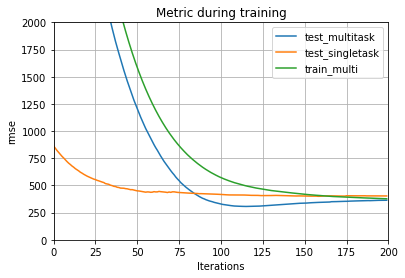

In [7]:
evals_result = {}
evals_result['test_multitask'] = evals_result_mt['valid_1']
evals_result['test_singletask'] = evals_result_singlelgb['valid_1']
evals_result['train_multi'] = evals_result_mt['training']

ax = lgb.plot_metric(evals_result, metric='rmse',ylim = (0,2000))
plt.show()

# XGBoost

In [8]:
import xgboost as xgb
startdate = "20191015"
features = [x for x in df_feature.columns if x not in ['report_date','amount','amount2']]

params = {
        "n_estimators":200,
    "max_depth":6,
    "learning_rate":0.03,
            'reg_alpha' :0.1,
        'reg_lambda' : 0.2,
    'num_leaves':48,
}


target = 'amount'
X_train = df_feature[df_feature['report_date']<startdate][features]
y_train = df_feature[df_feature['report_date']<startdate][target]
X_valid = df_feature[df_feature['report_date']>=startdate][features]
y_valid = df_feature[df_feature['report_date']>=startdate][target]

print(X_train.shape,X_valid.shape)
evals_result = {}
clf = xgb.XGBRegressor(
    **params
)
#     clf.fit(X_train, y_train)
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', np.mean(np.abs((labels - preds) / (labels+0.0001))))
def xgb_rmse(preds, dtrain):
    labels = dtrain.get_label()
    return('rmse', np.mean((labels-preds) ** 2)**0.5)    
clf.fit(X_train, y_train, eval_set = [(X_valid,y_valid)],eval_metric = xgb_rmse)



(942, 22) (31, 22)
[0]	validation_0-rmse:5875.17773	validation_0-rmse:5875.17761
[1]	validation_0-rmse:5695.03613	validation_0-rmse:5695.03591
[2]	validation_0-rmse:5519.79688	validation_0-rmse:5519.79655
[3]	validation_0-rmse:5350.89502	validation_0-rmse:5350.89506
[4]	validation_0-rmse:5186.15234	validation_0-rmse:5186.15233
[5]	validation_0-rmse:5027.33936	validation_0-rmse:5027.33926
[6]	validation_0-rmse:4872.51270	validation_0-rmse:4872.51249
[7]	validation_0-rmse:4721.35840	validation_0-rmse:4721.35849
[8]	validation_0-rmse:4576.19092	validation_0-rmse:4576.19121
[9]	validation_0-rmse:4434.04150	validation_0-rmse:4434.04172
[10]	validation_0-rmse:4298.22900	validation_0-rmse:4298.22894
[11]	validation_0-rmse:4165.65674	validation_0-rmse:4165.65649
[12]	validation_0-rmse:4037.68530	validation_0-rmse:4037.68510
[13]	validation_0-rmse:3911.56079	validation_0-rmse:3911.56094
[14]	validation_0-rmse:3791.75855	validation_0-rmse:3791.75869
[15]	validation_0-rmse:3676.58203	validation_0

[132]	validation_0-rmse:333.38583	validation_0-rmse:333.38586
[133]	validation_0-rmse:332.93445	validation_0-rmse:332.93446
[134]	validation_0-rmse:335.27643	validation_0-rmse:335.27641
[135]	validation_0-rmse:337.04837	validation_0-rmse:337.04838
[136]	validation_0-rmse:337.92270	validation_0-rmse:337.92270
[137]	validation_0-rmse:340.16708	validation_0-rmse:340.16711
[138]	validation_0-rmse:342.77698	validation_0-rmse:342.77697
[139]	validation_0-rmse:344.99463	validation_0-rmse:344.99462
[140]	validation_0-rmse:345.69949	validation_0-rmse:345.69950
[141]	validation_0-rmse:348.23062	validation_0-rmse:348.23061
[142]	validation_0-rmse:349.12918	validation_0-rmse:349.12917
[143]	validation_0-rmse:349.86261	validation_0-rmse:349.86261
[144]	validation_0-rmse:352.99084	validation_0-rmse:352.99086
[145]	validation_0-rmse:353.05707	validation_0-rmse:353.05706
[146]	validation_0-rmse:355.96195	validation_0-rmse:355.96197
[147]	validation_0-rmse:356.66861	validation_0-rmse:356.66859
[148]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, num_leaves=48, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.1,
             reg_lambda=0.2, scale_pos_weight=1, subsample=1,
             tree_method='auto', verbosity=1)